In [8]:
#coding=utf-8
# ------------------------------------------------------------------------------------------#
# 
#-------------------------------------------------------------------------------------------#
from netCDF4 import Dataset as ncfile
from netCDF4 import num2date, date2num
import datetime
import numpy as np
import numpy.ma as ma
import math
import matplotlib.dates as dates
from pyproj import Proj, transform
import scipy
from scipy import spatial
import warnings
warnings.filterwarnings("ignore")

In [3]:
era5in  = 'https://thredds.met.no/thredds/dodsC/metusers/maltem/MOSAiC/Arctic.ERA5.icesurface.2019.nc'
modisin = 'https://thredds.met.no/thredds/dodsC/metusers/maltem/MOSAiC/MODIS.surfacetemp.2019.nc'

In [5]:
# ----- ERA5 Grid information
era5dataset = ncfile(era5in, 'r')
   
era5_lons = era5dataset.variables['lon'][:]
era5_lats = era5dataset.variables['lat'][:]
era5_times = era5dataset.variables['time'][:]
t_unit = era5dataset.variables['time'].units
t_cal = era5dataset.variables['time'].calendar
era5_nctimes=[]; era5_nctimes.append(num2date(era5_times,units = t_unit,calendar = t_cal))
era5_nctimenum = np.squeeze(dates.date2num(era5_nctimes))
 
# ----- MODIS Grid information    
modisdataset = ncfile(modisin, 'r')       
modis_lons = modisdataset.variables['longitude'][:,:]
modis_lats = modisdataset.variables['latitude'][:,:]
modis_x = modisdataset.variables['x'][:]
modis_y = modisdataset.variables['y'][:]
modis_times = modisdataset.variables['time'][:]
t_unit = modisdataset.variables['time'].units
modis_nctimes=[]; modis_nctimes.append(num2date(modis_times,units = t_unit,calendar = 'proleptic_gregorian'))
modis_nctimenum = np.squeeze(dates.date2num(modis_nctimes))

In [6]:
# Find nearest neighbor point index
def do_kdtree(combined_x_y_arrays,points):
        mytree = scipy.spatial.cKDTree(combined_x_y_arrays)
        dist, indexes = mytree.query(points)
        return indexes
    
# projection of the grid -> era5 on to modis       
def remapfield(era5var,idx_pos_ij):
    era5projvar=np.zeros(np.shape(idx_pos_ij))
    for i in range(np.shape(idx_pos_ij)[0]):
        for j in range(np.shape(idx_pos_ij)[1]):
            era5projvar[i][j]=era5var[idx_pos_ij[i][j]]
    return era5projvar

In [9]:
era5_proj = Proj(init = 'epsg:4326')
modis_proj = Proj("+proj=stere +lat_0=90.0 +lon_0=-45.0 k_0=1.0 +x_0=0.0 +y_0=0.0 +no_defs +R=6378273.0")

In [11]:
era5_llon, era5_llat = np.meshgrid(era5_lons,era5_lats)
modis_xx, modis_yy   = np.meshgrid(modis_x, modis_y)

# Project all on MODIS grid
era5_xx,era5_yy = transform(era5_proj, modis_proj, era5_llon, era5_llat)

# Vectorize and concatenate the x,y coordinates
modis_xx_yy = np.dstack([modis_xx.ravel(), modis_yy.ravel()])[0]
era5_xx_yy  = np.dstack([era5_xx.ravel(), era5_yy.ravel()])[0]

#idx_pos = do_kdtree(modis_xx_yy, era5_xx_yy)     #Gives a field with dimensions of era5_xx_yy
idx_pos = do_kdtree( era5_xx_yy, modis_xx_yy)     #Gives a field with dimensions of modis_xx_yy

idx_pos_ij = idx_pos.reshape(np.shape(modis_xx))  #Gives a field with dimensions of modis_xx

### Test example one time-step of surface temperature

In [56]:
t = 498 #arbitrary timestep
era5time=era5_nctimenum[t]
tm = np.argmin(np.abs(era5time-modis_nctimenum))

tempmodis = modisdataset['aggregated_modis_ist'][tm,:,:]
temp      = era5dataset['SKT'][t,:,:]
tempproj  = remapfield(temp.ravel(),idx_pos_ij)

print(era5_nctimenum[t],modis_nctimenum[tm])

18161.041666666668 18161.041666666668


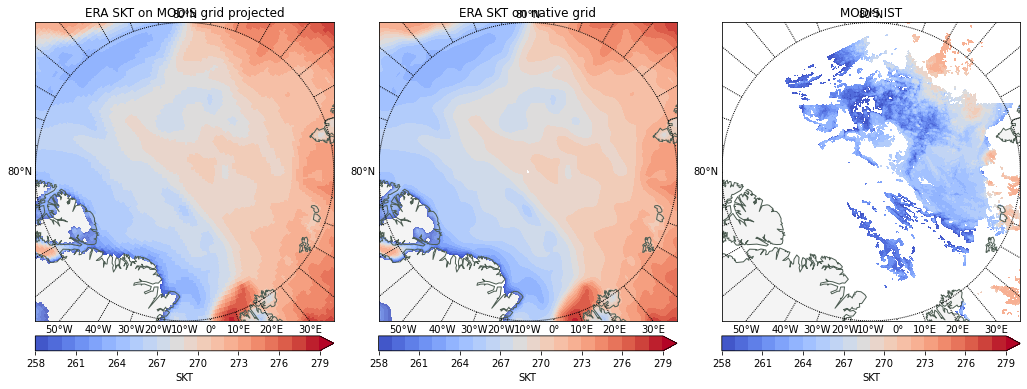

In [58]:
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

levelsT = range(258,280,1)
fig = plt.figure(figsize=(15.2,15.2)) 
gs = gridspec.GridSpec(1, 3)
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
m = Basemap(projection='npstere', boundinglat=80, lon_0=-10, lat_0=80, resolution='l')
#m = Basemap(projection='stere', 
#            boundinglat=75, lon_0=20, lat_0=75.4, 
#            resolution='l', 
#            llcrnrlat= 72.0, urcrnrlat=89.0, llcrnrlon=-50.0, urcrnrlon=50.0)

# PLOT (1) Projected on MODIS grid

ax = plt.subplot(gs[0],aspect='equal')
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(modis_lons),np.array(modis_lats))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( tempproj),
              cmap=plt.cm.coolwarm,extend='max',levels=levelsT)

plt.title ('ERA SKT on MODIS grid projected')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('SKT')    


# PLOT (2) Native grid ERA5
ax = plt.subplot(gs[1],aspect='equal')
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(era5_lons,era5_lats))
cs=m.contourf(x,y,np.array( temp),
              cmap=plt.cm.coolwarm,extend='max',levels=levelsT)
plt.title ('ERA SKT on native grid')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('SKT')  

# PLOT (1) Projected on MODIS grid

ax = plt.subplot(gs[2],aspect='equal')
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(modis_lons),np.array(modis_lats))               # compute map proj coordinates.
cs=m.contourf(x,y,tempmodis,
              cmap=plt.cm.coolwarm,extend='max',levels=levelsT)

plt.title ('MODIS IST')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('SKT')    

